In [1]:
import numpy as np
import pandas as pd
import math
import time
import re
import os
from skimage import util
from scipy.io import wavfile
from scipy import signal
from scipy import stats
import xarray as xr

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, cross_val_predict, GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.utils import resample

#visualizing results
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

C:\Users\Schindler\AppData\Local\conda\conda\envs\USV_python\lib\site-packages\distributed\utils.py:134: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [WinError 10065] A socket operation was attempted to an unreachable host
  % (host, default, e), RuntimeWarning)


Create data frame of annotation info

In [2]:
features_path = 'C:/Users/Schindler/Documents/ProgrammingFun/USV_python/annot_features_full.csv'
annot_features_data = pd.read_csv(features_path)
annot_features_full = pd.DataFrame(data = annot_features_data)
print(annot_features_full.shape)
print(annot_features_full.loc[pd.isna(annot_features_full['spec_pur'])].index)
annot_features_full.dropna(axis = 0, inplace=True)
print(annot_features_full.shape)
print(annot_features_full.loc[pd.isna(annot_features_full['spec_pur'])].index)
annot_features_full.head()

(959, 13)
Int64Index([], dtype='int64')
(959, 13)
Int64Index([], dtype='int64')


,Unnamed: 0,animal_number,session,time_stamp,Annotation,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll
0,0,527,cagepair,18922.5,high slug,44921.600,0.335974,40617.050954,117729.192000,6.831866,48.160918,0.000787,38586.198407
1,1,527,cagepair,24750.0,low slug,53212.637,0.295599,27042.548508,3827.200195,3.556462,20.402396,-0.000227,25690.421083
2,2,527,cagepair,56002.5,bbc,94253.766,0.189555,30090.095178,68103.292456,3.982554,18.393372,-0.002314,28585.590419
3,3,527,cagepair,174352.5,bbc,51008.836,0.306177,34324.170621,52563.703613,3.336529,10.448164,-0.001250,32607.962090
4,4,527,cagepair,342877.5,bbc,164846.110,0.144833,33090.921412,22861.514782,1.852232,3.185318,-0.001784,31436.375341


In [3]:
annot_features_full.groupby('Annotation').describe()

Unnamed: 0                                                             animal_number                                                             time_stamp                                                                                     power_sum                                                                                               spec_pur                                                                       spec_cent                                                                                                   spec_spread                                                                                                        spec_skew                                                                       spec_kurt                                                                              spec_slope                                                                       spec_roll                                                                        \
                count        mean         std   min     25%    50%     75%    max         count        mean        std    min     25%    50%     75%    max      count           mean            std      min         25%        50%         75%       max     count           mean            std        min          25%          50%           75%          max    count      mean       std       min       25%       50%       75%       max     count          mean           std           min           25%           50%           75%           max       count           mean            std           min           25%            50%            75%            max     count      mean       std       min       25%       50%       75%       max     count       mean        std        min        25%        50%        75%        max      count      mean       std       min       25%       50%       75%       max     count          mean           std           min           25%           50%   
Annotation                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
bbc              45.0   94.533333   55.230756   2.0   37.00  110.0  145.00  157.0          45.0  547.022222  12.083966  527.0  535.00  554.0  557.00  559.0       45.0  203221.000000  163944.266043  13590.0   60570.000  174352.50  276277.500  591255.0      45.0  187049.752200  163252.249644  51008.836  108528.2660  142034.1900  185542.44000    872012.60     45.0  0.135980  0.063951  0.026119  0.091080  0.126480  0.173507  0.306177      45.0  32096.112594   3592.063646  25317.517312  30090.095178  31762.963636  34324.170621  41218.670832        45.0  106052.164971   57973.683260  22861.514782  68103.292456   95060.654641  149716.189200  272975.403907      45.0  3.616554  1.064733  1.420153  3.056477  3.603695  4.080782  5.614859      45.0  14.507654   8.570242   1.158310  10.448164  13.066885  18.996466  34.298438       45.0 -0.002336  0.000402 -0.002793 -0.002664 -0.002428 -0.002093 -0.001040      45.0  30491.306964   3412.460464  24051.641447  28585.590419  30174.815454   
high multi        4.0   89.500000   51.045731  23.0   62.75

In [6]:
annot_features_bbc = annot_features_full[(annot_features_full['Annotation'] == 'bbc') | (annot_features_full['Annotation'] == 'rand_noise')]
print(annot_features_bbc.shape)
annot_features_bbc.head()

(845, 13)


,Unnamed: 0,animal_number,session,time_stamp,Annotation,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll
2,2,527,cagepair,56002.5,bbc,94253.766,0.189555,30090.095178,68103.292456,3.982554,18.393372,-0.002314,28585.590419
3,3,527,cagepair,174352.5,bbc,51008.836,0.306177,34324.170621,52563.703613,3.336529,10.448164,-0.001250,32607.962090
4,4,527,cagepair,342877.5,bbc,164846.110,0.144833,33090.921412,22861.514782,1.852232,3.185318,-0.001784,31436.375341
5,5,527,cagepair,393052.5,bbc,112545.530,0.173507,38295.842887,92458.515662,2.972260,8.682456,-0.002068,36381.050743
6,6,527,cagepair,398677.5,bbc,597764.750,0.048523,37976.268300,201586.276943,4.767173,24.812686,-0.002563,36077.454885


In [7]:
#separate and save for later testing dataset
train_orig, test_orig = train_test_split(annot_features_bbc, test_size=0.3, random_state=1, stratify = annot_features_bbc.Annotation)

In [8]:
train_orig_maj = train_orig[train_orig['Annotation'] == 'rand_noise']
train_orig_min = train_orig[train_orig['Annotation'] != 'rand_noise']

train_orig_min_upsamples = resample(train_orig_min, replace=True, n_samples = len(train_orig_maj), random_state = 123)

train_orig_upsamples = pd.concat([train_orig_min_upsamples, train_orig_maj])

print(train_orig_upsamples.Annotation.value_counts())

train_orig_upsamples.head()

bbc           560
rand_noise    560
Name: Annotation, dtype: int64


,Unnamed: 0,animal_number,session,time_stamp,Annotation,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll
154,154,559,CPApair,38542.5,bbc,189631.310,0.083469,36864.114756,159113.458966,3.686594,13.066885,-0.002547,35020.909018
125,125,556,cagepair,41625.0,bbc,108528.266,0.200593,36089.208727,35109.887498,2.983860,10.755988,-0.001694,34284.748290
154,154,559,CPApair,38542.5,bbc,189631.310,0.083469,36864.114756,159113.458966,3.686594,13.066885,-0.002547,35020.909018
109,109,554,CPApair,194917.5,bbc,169526.390,0.087578,30706.674848,148978.736880,3.767604,13.329037,-0.002770,29171.341105
108,108,554,CPApair,150997.5,bbc,159985.560,0.086067,25428.290261,126332.697535,4.080782,15.555153,-0.002674,24156.875748


In [9]:
groups = train_orig_upsamples['Unnamed: 0'].values
annot_labels_up = train_orig_upsamples['Annotation']
annot_labels_up = annot_labels_up.replace(regex={r'bbc': 1, 'rand_noise': 0})

In [10]:
annot_features_up = train_orig_upsamples[['power_sum', 'spec_pur', 'spec_cent', 'spec_spread', 'spec_skew',
       'spec_kurt', 'spec_slope', 'spec_roll']]
annot_features_up.head()

,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll
154,189631.310,0.083469,36864.114756,159113.458966,3.686594,13.066885,-0.002547,35020.909018
125,108528.266,0.200593,36089.208727,35109.887498,2.983860,10.755988,-0.001694,34284.748290
154,189631.310,0.083469,36864.114756,159113.458966,3.686594,13.066885,-0.002547,35020.909018
109,169526.390,0.087578,30706.674848,148978.736880,3.767604,13.329037,-0.002770,29171.341105
108,159985.560,0.086067,25428.290261,126332.697535,4.080782,15.555153,-0.002674,24156.875748


In [11]:
group_k_fold = GroupKFold(n_splits=3)
cv = list(group_k_fold.split(annot_features_up, annot_labels_up, groups))

In [12]:
# center and scale the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(annot_features_up)

In [13]:
lr_cv = LogisticRegression(random_state=0)
rf_cv = RandomForestClassifier(max_depth=10, random_state=0)
svm_cv = SVC(probability=True) 

In [14]:
y_pred_lr = cross_val_predict(lr_cv, features_scaled, annot_labels_up, cv=cv, method='predict')
y_pred_prob_lr = cross_val_predict(lr_cv, features_scaled, annot_labels_up, cv=cv, method='predict_proba')
conf_mat_lr = confusion_matrix(annot_labels_up, y_pred_lr)
conf_mat_lr

array([[553,   7],
       [  0, 560]], dtype=int64)

In [15]:
y_pred_rf = cross_val_predict(rf_cv, features_scaled, annot_labels_up, cv=cv, method='predict')
y_pred_prob_rf = cross_val_predict(rf_cv, features_scaled, annot_labels_up, cv=cv, method='predict_proba')
conf_mat_rf = confusion_matrix(annot_labels_up, y_pred_rf)
conf_mat_rf

array([[559,   1],
       [ 57, 503]], dtype=int64)

In [16]:
y_pred_svm = cross_val_predict(svm_cv, features_scaled, annot_labels_up, cv=cv, method='predict')
y_pred_prob_svm = cross_val_predict(svm_cv, features_scaled, annot_labels_up, cv=cv, method='predict_proba')
conf_mat_svm = confusion_matrix(annot_labels_up, y_pred_svm)
conf_mat_svm

array([[556,   4],
       [  0, 560]], dtype=int64)

In [17]:
# calculate some of these metrics using sklearn and the test set samples
print("Sensitivity/Recall (TPR): ",metrics.recall_score(annot_labels_up,y_pred_lr))
print("Precision (PPV): ", metrics.precision_score(annot_labels_up,y_pred_lr))
print("Accuracy: ", metrics.accuracy_score(annot_labels_up,y_pred_lr))
print("F1:", metrics.f1_score(annot_labels_up,y_pred_lr))

Sensitivity/Recall (TPR):  1.0
Precision (PPV):  0.9876543209876543
Accuracy:  0.99375
F1: 0.9937888198757764


In [18]:
# calculate some of these metrics using sklearn and the test set samples
print("Sensitivity/Recall (TPR): ",metrics.recall_score(annot_labels_up,y_pred_rf))
print("Precision (PPV): ", metrics.precision_score(annot_labels_up,y_pred_rf))
print("Accuracy: ", metrics.accuracy_score(annot_labels_up,y_pred_rf))
print("F1:", metrics.f1_score(annot_labels_up,y_pred_rf))

Sensitivity/Recall (TPR):  0.8982142857142857
Precision (PPV):  0.998015873015873
Accuracy:  0.9482142857142857
F1: 0.9454887218045113


In [19]:
# calculate some of these metrics using sklearn and the test set samples
print("Sensitivity/Recall (TPR): ",metrics.recall_score(annot_labels_up,y_pred_svm))
print("Precision (PPV): ", metrics.precision_score(annot_labels_up,y_pred_svm))
print("Accuracy: ", metrics.accuracy_score(annot_labels_up,y_pred_svm))
print("F1:", metrics.f1_score(annot_labels_up,y_pred_svm))

Sensitivity/Recall (TPR):  1.0
Precision (PPV):  0.9929078014184397
Accuracy:  0.9964285714285714
F1: 0.9964412811387899


In [20]:
print("Logistic regression ROC_AUC: ", metrics.roc_auc_score(annot_labels_up, y_pred_prob_lr[:,1]))
print("Random forest ROC_AUC: ", metrics.roc_auc_score(annot_labels_up, y_pred_prob_rf[:,1]))
print("SVM ROC_AUC: ", metrics.roc_auc_score(annot_labels_up, y_pred_prob_svm[:,1]))

Logistic regression ROC_AUC:  0.99828125
Random forest ROC_AUC:  0.9829272959183674
SVM ROC_AUC:  0.9990848214285715


Text(0, 0.5, 'True Positive Rate (Sensitivity)')

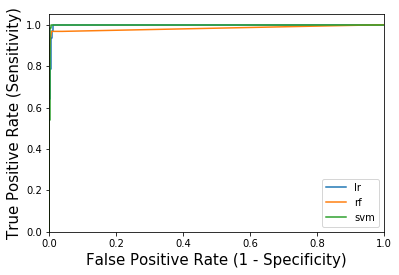

In [21]:
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(annot_labels_up, y_pred_prob_lr[:,1])
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(annot_labels_up, y_pred_prob_rf[:,1])
fpr_svm, tpr_svm, thresholds_svm = metrics.roc_curve(annot_labels_up, y_pred_prob_svm[:,1])
# plot LR model ROC curves
plt.plot(fpr_lr, tpr_lr,label="lr")
plt.plot(fpr_rf, tpr_rf,label="rf")
plt.plot(fpr_svm, tpr_svm,label="svm")
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize = 15)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize = 15)

Text(0, 0.5, 'Precision')

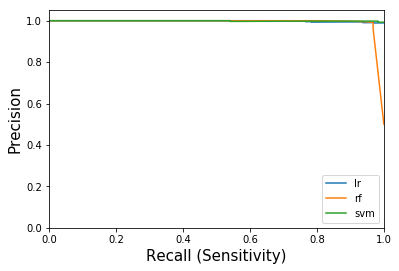

In [22]:
# calculate precision-recall curve
precision_lr, recall_lr, thresholds_pr_lr = metrics.precision_recall_curve(annot_labels_up, y_pred_prob_lr[:,1])
precision_rf, recall_rf, thresholds_pr_rf = metrics.precision_recall_curve(annot_labels_up, y_pred_prob_rf[:,1])
precision_svm, recall_svm, thresholds_pr_svm = metrics.precision_recall_curve(annot_labels_up, y_pred_prob_svm[:,1])

plt.plot(recall_lr, precision_lr, label='lr')
plt.plot(recall_rf, precision_rf, label='rf')
plt.plot(recall_svm, precision_svm, label='svm')

plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="lower right")
plt.xlabel('Recall (Sensitivity)', fontsize = 15)
plt.ylabel('Precision', fontsize = 15)

Text(0, 0.5, 'True Positive Rate (Sensitivity) or Class 1 Threshold Probability')

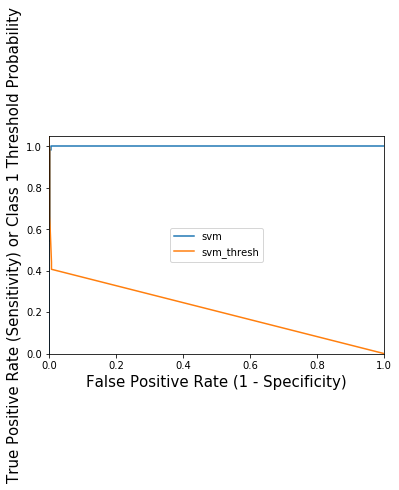

In [26]:
# plot LR and RF model ROC curves
plt.plot(fpr_svm, tpr_svm, label="svm")
plt.plot(fpr_svm, thresholds_svm, label="svm_thresh")
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="center")
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize= 15)
plt.ylabel('True Positive Rate (Sensitivity) or Class 1 Threshold Probability', fontsize = 15)

In [27]:
train_orig_upsamples['pred_lr'] = y_pred_prob_lr[:,1]
train_orig_upsamples['pred_rf'] = y_pred_prob_rf[:,1]
train_orig_upsamples['pred_svm'] = y_pred_prob_svm[:,1]
train_orig_upsamples['class_actual'] = annot_labels_up
train_orig_upsamples['class_svm'] = y_pred_svm
train_orig_upsamples.head()

,Unnamed: 0,animal_number,session,time_stamp,Annotation,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll,pred_lr,pred_rf,pred_svm,class_actual,class_svm
154,154,559,CPApair,38542.5,bbc,189631.310,0.083469,36864.114756,159113.458966,3.686594,13.066885,-0.002547,35020.909018,0.999935,1.0,1.000000,1,1
125,125,556,cagepair,41625.0,bbc,108528.266,0.200593,36089.208727,35109.887498,2.983860,10.755988,-0.001694,34284.748290,0.930994,0.6,0.992770,1,1
154,154,559,CPApair,38542.5,bbc,189631.310,0.083469,36864.114756,159113.458966,3.686594,13.066885,-0.002547,35020.909018,0.999935,1.0,1.000000,1,1
109,109,554,CPApair,194917.5,bbc,169526.390,0.087578,30706.674848,148978.736880,3.767604,13.329037,-0.002770,29171.341105,0.999727,1.0,1.000000,1,1
108,108,554,CPApair,150997.5,bbc,159985.560,0.086067,25428.290261,126332.697535,4.080782,15.555153,-0.002674,24156.875748,0.995460,1.0,0.978012,1,1


In [28]:
train_orig_upsamples.groupby('Annotation')['pred_lr', 'pred_rf', 'pred_svm'].describe()

pred_lr                                                                          pred_rf                                              pred_svm                                                                      
             count      mean       std           min      25%       50%       75%       max   count      mean       std  min  25%  50%  75%  max    count      mean       std       min       25%       50%       75%       max
Annotation                                                                                                                                                                                                                     
bbc          560.0  0.959409  0.098196  5.342939e-01  0.97687  0.995283  0.999100  0.999987   560.0  0.861786  0.236485  0.0  0.8  1.0  1.0  1.0    560.0  0.948262  0.115362  0.406836  0.976219  0.995820  1.000000  1.000000
rand_noise   560.0  0.022311  0.097252  7.997806e-07  0.00120  0.002148  0.010904  0.985724   560.0  0.008750  0.051924  0.0  0.0  0.0  0.0  0.6    560.0  0.006934  0.056450  0.000015  0.000506  0.000897  0.002121  0.994142

In [29]:
preds = []
for index, row in train_orig_upsamples.iterrows():
    if (row['class_actual'] == 0) & (row['class_svm'] == 0):
        pred = 'TN'
    if (row['class_actual'] == 0) & (row['class_svm'] == 1):
        pred = 'FP'
    if (row['class_actual'] == 1) & (row['class_svm'] == 1):
        pred = 'TP'
    if (row['class_actual'] == 1) & (row['class_svm'] == 0):
        pred = 'FN'
    preds.append(pred)
    
train_orig_upsamples['pred'] = preds

In [30]:
train_orig_upsamples.groupby('pred').describe()

Unnamed: 0                                                             animal_number                                                            time_stamp                                                                                     power_sum                                                                                             spec_pur                                                                       spec_cent                                                                                                  spec_spread                                                                                                       spec_skew                                                                       spec_kurt                                                                            spec_slope                                                                       spec_roll                                                                                     \
          count        mean         std   min     25%    50%     75%    max         count       mean        std    min     25%    50%     75%    max      count           mean            std      min         25%        50%         75%       max     count           mean            std        min          25%          50%          75%         max    count      mean       std       min       25%       50%       75%       max     count          mean          std           min           25%           50%           75%           max       count           mean           std           min           25%            50%            75%            max     count      mean       std       min       25%       50%       75%       max     count       mean        std       min       25%        50%        75%        max      count      mean       std       min       25%       50%       75%       max     count          mean          std           min           25%           50%           75%   
pred                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
FP          4.0  401.250000  325.276677  98.0  144.50  368.0  624.75  771.0           4.0  544.00000  14.719601  529.0  532.75  544.0  555.25  559.0        4.0  292865.625000  171568.087655  55170.0  225708.750  338827.50  405984.375  438637.5       4.0  163811.950000  222583.875433  35356.900   40033.7350   61825.2000  185603.4150    496240.5      4.0  0.133352  0.083610  0.019761  0.109518  0.146488  0.170322  0.220670       4.0  25982.188017  3970.559301  20745.437066  24065.121479  26747.631510  28664.698049  29688.051984         4.0   87663.445817  67196.033670  38830.506112  39689.477875   64957.809488  112931.777430  181907.658179       4.0  4.037389  1.539482  2.569924  2.843463  3.894708  5.088634  5.790215       4.0  18.043932  13.069900  6.736067  7.646579  15.756672  26.154025  33.926320        4.0 -0.002299  0.000222 -0.002525 -0.002447 -0.002323 -0.002175 -0.002023       4.0  24683.078617  3772.031336  19708.165212  22861.865405  25410.249934  27231.463146   
TN        556.0  397.278777  231.046159   0.0  200.75

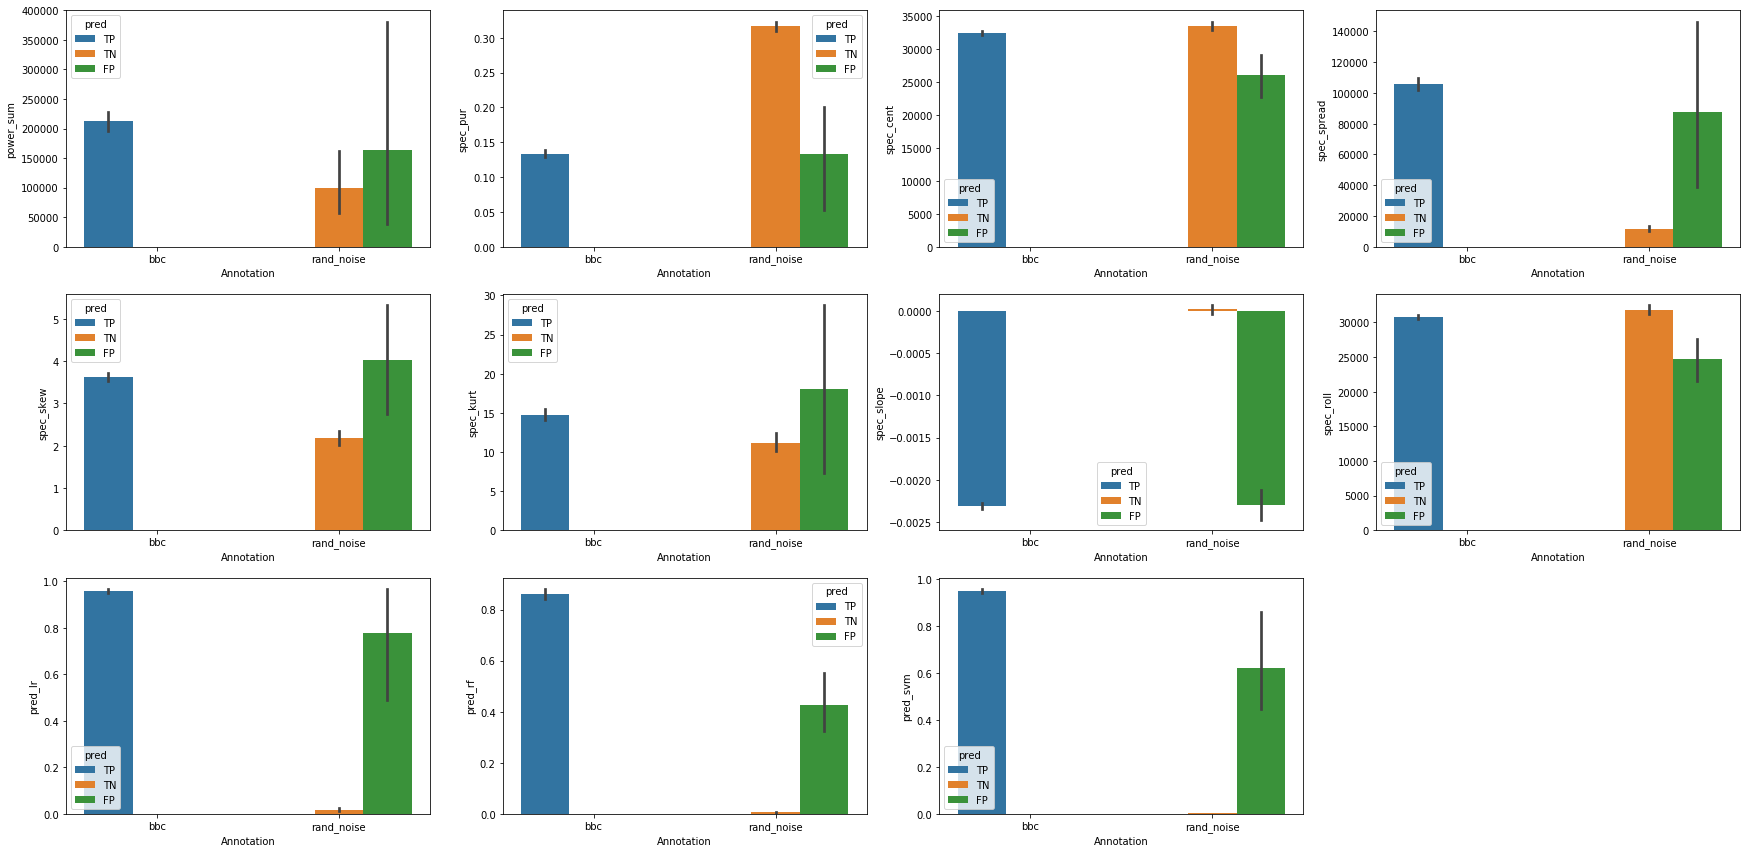

In [31]:
feat_col = ['power_sum', 'spec_pur', 'spec_cent', 'spec_spread', 'spec_skew',
       'spec_kurt', 'spec_slope', 'spec_roll', 'pred_lr', 'pred_rf',
       'pred_svm']

i=1
plt.figure(figsize=(30,20))
for name in feat_col:
    plt.subplot(4, 4, i)
    sns.barplot(x="Annotation", y=name, hue="pred", data=train_orig_upsamples)
    i = i + 1

In [32]:
false_neg_unique = train_orig_upsamples[train_orig_upsamples['pred'] == 'FN'].drop_duplicates()
i = 1
plt.figure(figsize=(30,30))
for index, row in false_neg_unique.iterrows():
    data = xr.open_dataset('C:/Users/Schindler/Documents/ProgrammingFun/USV_python/Datasets/' + str(row['animal_number']) + '_xr_Dataset.nc')
    
    data_slice = data['__xarray_dataarray_variable__'].sel(slices=row['time_stamp'])
    times = data['times'].values
    freqs = data['freq'].values
    
    max_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).max(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
    #min_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).min(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
    
    plt.subplot(5, 5, i)
    xr.ufuncs.log(data_slice).plot(cmap='magma', vmin=0, vmax = max_value*.7)
    
    i = i + 1

<Figure size 2160x2160 with 0 Axes>

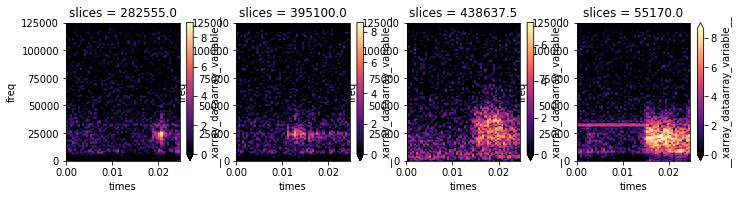

In [33]:
false_pos_unique = train_orig_upsamples[train_orig_upsamples['pred'] == 'FP'].drop_duplicates()
i = 1
plt.figure(figsize=(30,30))
for index, row in false_pos_unique.iterrows():
    data = xr.open_dataset('C:/Users/Schindler/Documents/ProgrammingFun/USV_python/Datasets/' + str(row['animal_number']) + '_xr_Dataset.nc')
    
    data_slice = data['__xarray_dataarray_variable__'].sel(slices=row['time_stamp'])
    times = data['times'].values
    freqs = data['freq'].values
    
    max_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).max(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
    #min_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).min(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
    
    plt.subplot(10, 10, i)
    xr.ufuncs.log(data_slice).plot(cmap='magma', vmin=0, vmax = max_value*.7)
    
    i = i + 1